In this tutorial, we will show best practices in using PathML from start to finish in training and evaluating two kinds of models, a classification model and a segmentation model, on a subset of whole-slide images that come from the CAMELYON16 dataset. These images show breast lymph nodes, and the task is to identify slides and/or regions of the slides which contain breast cancer metastases. We have ground truth annotations for all slides from expert pathologists. Although the full dataset contains 400 WSIs, we have created a microdataset of 18 of these slides for the purposes of this tutorial: 6 training slides, 6 validation slides, and 6 testing slides, each with 3 metastasis-containing/tumor slides and 3 negative slides.

First, we must import the libraries we need to run this tutorial. Please change the pathml and pathml-tutorial paths to your installation paths (indicated below with comments). PathML can be downloaded from here: https://github.com/markowetzlab/pathml

NOTE: If during the PathML import below, an error occurs with a message referencing something from libvips being missing, this is an issue with installing pyvips via pip. To solve this issue, run the following command inside your pathml-env conda environment to install the conda distribution of pyvips:

```conda install -c conda-forge pyvips```

In [1]:
import glob
import os
import pickle
import sys
from pathlib import Path
import random
from tqdm import tqdm

# change these to your local paths
sys.path.append('/home/cri.camres.org/berman01/Documents/pathml') # not necessary if you install PathML with pip
#sys.path.append('/path/to/pathml-tutorial/Pytorch-UNet')

from pathml.slide import Slide

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import albumentations as A
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import time
#import logging

#from unet import UNet
#from eval import eval_net
#from utils.dataset import PathmlSegmentationDataset, visualizeSegmentationAugmentation
#from torch.utils.data import DataLoader, random_split
#from dice_loss import dice_coeff

Let's define some constants and paths and make some directories we'll need. Make a wsi_data directory and populate it with the WSIs named below. These WSIs can be found in the tumor and normal folders at the follwing link: [[]]

Make sure to change the path to the analysis directory (analysis_dir_path) to the directory where you will be working on your machine (same with the the path to wsi_data)!

In [15]:
# change to your local paths
analysis_dir_path = '/media/berman01/Expansion/benchmark_deep_tissue_detector'
wsi_path = '/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis'

pathml_slide_dir_path = os.path.join(analysis_dir_path, 'pathml_slides')
annotations_dir_path = os.path.join(analysis_dir_path, 'annotations')

os.makedirs(analysis_dir_path, exist_ok=True)
os.makedirs(pathml_slide_dir_path, exist_ok=True)
os.makedirs(annotations_dir_path, exist_ok=True)
os.makedirs(os.path.join(analysis_dir_path, 'results'), exist_ok=True)

tcga_tgct_cases = ['TCGA-2G-AAGK-01Z-00-DX1.D0530A91-8CA1-47AA-95AF-AB7B901DC5B6', 
         'TCGA-2G-AAHN-01Z-00-DX1.B5CCB104-C436-4B80-8F47-EB9C7D13ACF0', 
         'TCGA-2G-AAKD-01Z-00-DX1.137A7B81-38C0-4715-BF9A-64BDB219DB9A', 
         'TCGA-2G-AAKO-05Z-00-DX1.2668F339-535C-4981-ADF7-9B47C15ED272', 
         'TCGA-YU-A94D-01Z-00-DX1.9B1832C3-F7CA-410A-AC74-28FCB282D05D',
        'TCGA-XE-A8H1-01A-01-TS1.12D10019-B0AC-4476-88F1-6996102A0D22']
camelyon_cases = ['normal_004', 'normal_042', 'tumor_021', 'tumor_031', 'tumor_051', 'tumor_092']
occams_cases = ['OC-AH-005_OGD_1-III-IV-MAYBE-HGD', 'OC-AH-005_OGD_1-I-II-MAYBE-HGD',
               'OC-AH-005_OGD_2-III-IV', 'OC-AH-124_OGD_K-I-II', 'OC-AH-153_OGD_3-III',
               'OC-AH-645_OGD_A1-SRS']
best_cases = ['BEST2 CAM 0003 HE - 2020-11-11 15.59.22', 'BEST2 CAM 0007 HE - 2020-11-11 16.28.24',
             'BEST2 CAM 0419 R1 P53 - LOOKS WEIRD 2021-06-08 14.08.34', 'BEST2 CDD 0004 R1 P53 - ARTIFACT EVERYWHERE 2021-06-08 13.36.39',
             'BEST2 NEW 0027 HE - LARGE ARTIFACT - 2020-11-12 16.56.07', 'BEST2 NEW 0189 P53 - MASSIVE ARTIFACT MAYBE RESCAN - 2020-12-29 21.11.36']
tcga_prad_cases = ['TCGA-YL-A8SL-01Z-00-DX2.F64D1539-E590-4B51-96B4-1F95CAE6E33A', 'TCGA-YL-A8SJ-01Z-00-DX2.36E46E11-79CA-4356-B68F-F387219B3D16',
                  'TCGA-YL-A8SI-01Z-00-DX1.35E5FB1A-9AAC-4942-892B-E9D80F6BDA23', 'TCGA-G9-6378-01A-01-BS1.bc59e095-f3ab-4a6e-8cef-ea7fc76abec8',
                  'TCGA-G9-7509-01Z-00-DX1.D75B78D5-F5B9-4684-9FE0-C7279122D66F', 'TCGA-G9-6333-11A-01-TS1.924c9301-78b6-4330-be95-533b25cf1a91']
cases = tcga_tgct_cases + camelyon_cases + occams_cases + best_cases + tcga_prad_cases
wsi_paths = [os.path.join(wsi_path, case+'.svs') for case in tcga_tgct_cases]+[os.path.join(wsi_path, case+'.tif') for case in camelyon_cases]+[os.path.join(wsi_path, case+'.svs') for case in occams_cases]+[os.path.join(wsi_path, case+'.ndpi') for case in best_cases]+[os.path.join(wsi_path, case+'.svs') for case in tcga_prad_cases] 
print(wsi_paths)
#print(wsi_paths[12:])


['/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-2G-AAGK-01Z-00-DX1.D0530A91-8CA1-47AA-95AF-AB7B901DC5B6.svs', '/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-2G-AAHN-01Z-00-DX1.B5CCB104-C436-4B80-8F47-EB9C7D13ACF0.svs', '/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-2G-AAKD-01Z-00-DX1.137A7B81-38C0-4715-BF9A-64BDB219DB9A.svs', '/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-2G-AAKO-05Z-00-DX1.2668F339-535C-4981-ADF7-9B47C15ED272.svs', '/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-YU-A94D-01Z-00-DX1.9B1832C3-F7CA-410A-AC74-28FCB282D05D.svs', '/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-XE-A8H1-01A-01-TS1.12D10019-B0AC-4476-88F1-6996102A0D22.svs', '/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/normal_004.tif', '/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/normal_042.tif', '/media/berman01/Expansion/benchmark_deep_tissue_detector/w

First we'll define a pathml Slide object for each whole-slide image (WSI). We can use PathML to break the image up into tiles of the desired size and separate all tiles showing background and artifact from those showing actual tissue. We can then add annotations for our ground truth tissue regions. When adding annotations, make sure to set the name of the class for "donut hole" or negative regions to extract from other annotations with the negativeClass argument of Slide.addAnnotations().

NOTE: Some users may find that progress freezes as the first WSI is being run through Slide.detectTissue(). This is a PyTorch issue. If this happens to you, set numWorkers=0 in the Slide.detectTissue() call, and tissue detection should proceed (albeit slowly). The default of numWorkers in Slide.detectTissue() is 16. (2m 31s)

In [23]:
start_time = time.time()

tile_size = 500 # pixels

for wsi_path in wsi_paths[24:]:#wsi_paths:
    case = Path(wsi_path).stem
    pathml_slide = Slide(wsi_path, level=0).setTileProperties(tileSize=tile_size)
    
    annotation_path = os.path.join(analysis_dir_path, 'annotations', case+'.xml')
    print(annotation_path)
    pathml_slide.addAnnotations(annotation_path, negativeClass='negative')
    
    if case in camelyon_cases:
        pathml_slide.detectForeground(level=4)
    elif case in tcga_tgct_cases:
        pathml_slide.detectForeground(level=2)
    elif case in occams_cases:
        pathml_slide.detectForeground(level=2)
    elif case in best_cases:
        pathml_slide.detectForeground(level=4)
    elif case in tcga_prad_cases:
        pathml_slide.detectForeground(level=2)
        
    pathml_slide.detectTissue(tissueDetectionLevel=0) 
    
    pathml_slide.save(folder=pathml_slide_dir_path)
    
time_elapsed = time.time() - start_time
print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-YL-A8SL-01Z-00-DX2.F64D1539-E590-4B51-96B4-1F95CAE6E33A.xml
Scale: 1.0
xml file valid - 45 annotation(s) found.
34 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-YL-A8SL-01Z-00-DX2.F64D1539-E590-4B51-96B4-1F95CAE6E33A.svs


100%|██████████| 1940/1940 [04:03<00:00,  7.97it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-YL-A8SJ-01Z-00-DX2.36E46E11-79CA-4356-B68F-F387219B3D16.xml
Scale: 1.0
xml file valid - 40 annotation(s) found.
36 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-YL-A8SJ-01Z-00-DX2.36E46E11-79CA-4356-B68F-F387219B3D16.svs


100%|██████████| 1642/1642 [03:33<00:00,  7.70it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-YL-A8SI-01Z-00-DX1.35E5FB1A-9AAC-4942-892B-E9D80F6BDA23.xml
Scale: 1.0
xml file valid - 24 annotation(s) found.
19 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-YL-A8SI-01Z-00-DX1.35E5FB1A-9AAC-4942-892B-E9D80F6BDA23.svs


100%|██████████| 1064/1064 [02:11<00:00,  8.08it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-G9-6378-01A-01-BS1.bc59e095-f3ab-4a6e-8cef-ea7fc76abec8.xml
Scale: 1.0
xml file valid - 14 annotation(s) found.
13 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-G9-6378-01A-01-BS1.bc59e095-f3ab-4a6e-8cef-ea7fc76abec8.svs


100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-G9-7509-01Z-00-DX1.D75B78D5-F5B9-4684-9FE0-C7279122D66F.xml
Scale: 1.0
xml file valid - 6 annotation(s) found.
2 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-G9-7509-01Z-00-DX1.D75B78D5-F5B9-4684-9FE0-C7279122D66F.svs


100%|██████████| 1281/1281 [02:21<00:00,  9.03it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-G9-6333-11A-01-TS1.924c9301-78b6-4330-be95-533b25cf1a91.xml
Scale: 1.0
xml file valid - 5 annotation(s) found.
2 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-G9-6333-11A-01-TS1.924c9301-78b6-4330-be95-533b25cf1a91.svs


100%|██████████| 260/260 [00:38<00:00,  6.84it/s]

Complete in 14m 34s


Let's check to make sure the tissue detector is filtering the tiles we want and compare the results to Otsu's method and the triangle algorithm on our six validation slides: (48s)

/home/cri.camres.org/berman01/Documents/pathml/pathml/slide.py:2184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


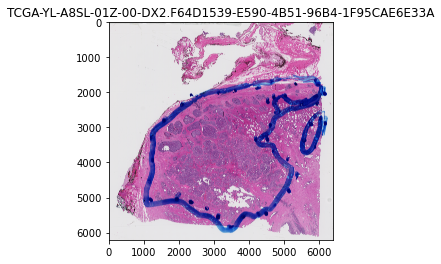

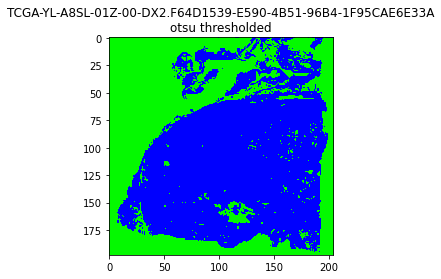

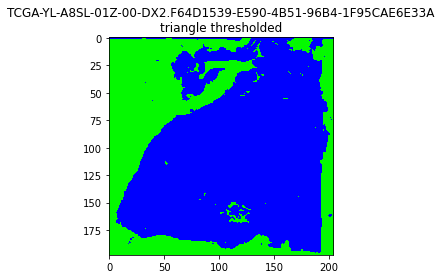

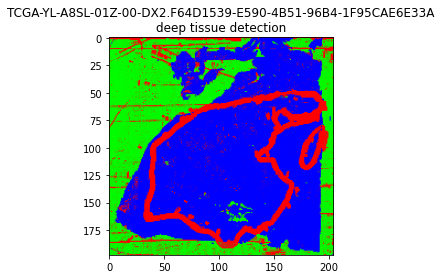

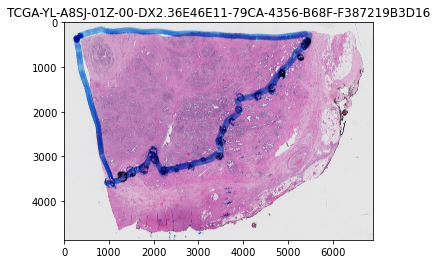

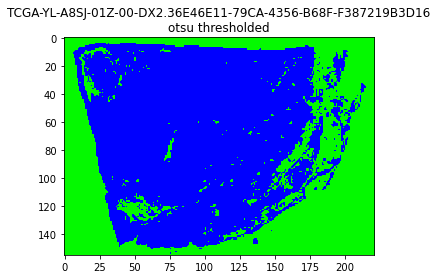

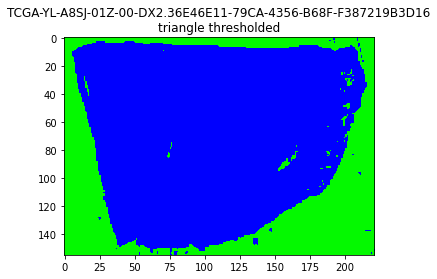

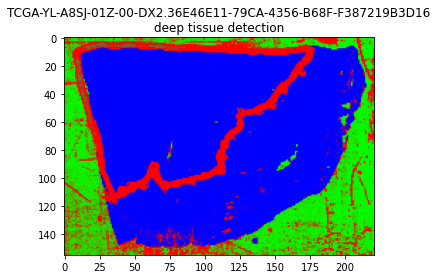

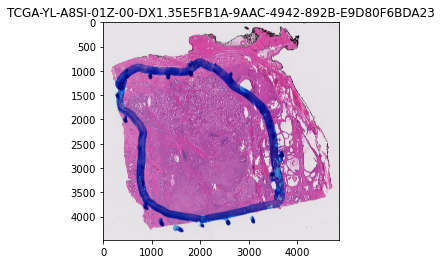

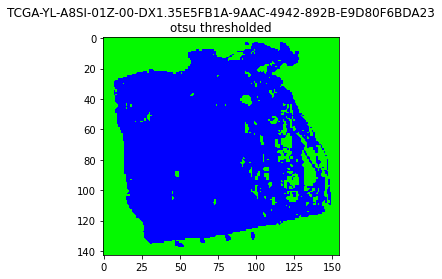

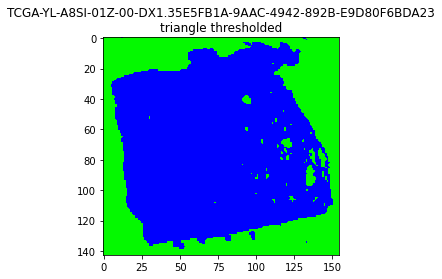

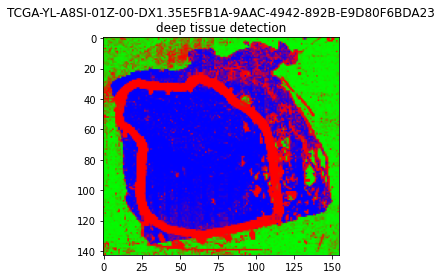

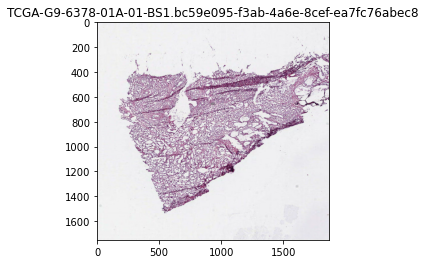

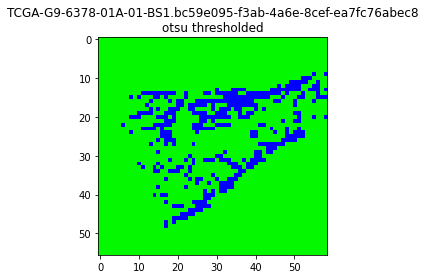

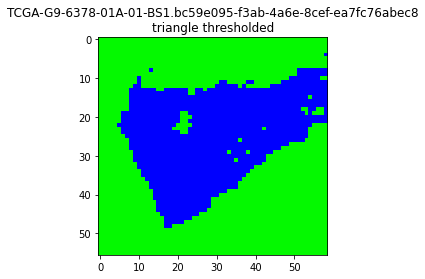

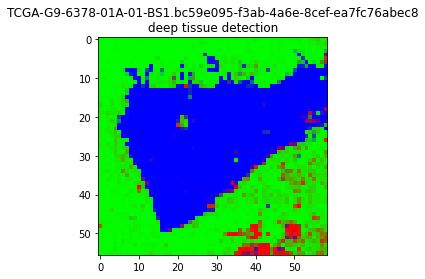

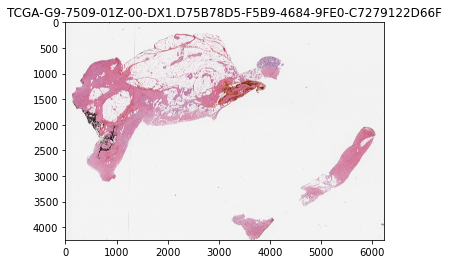

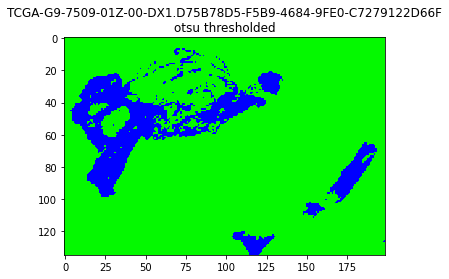

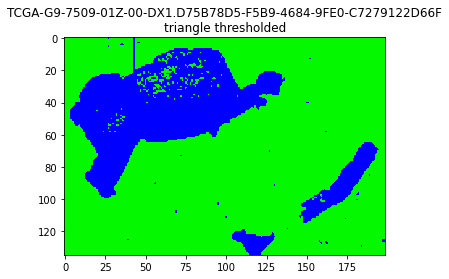

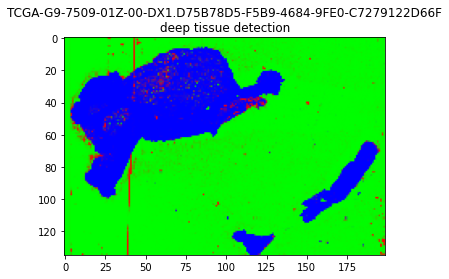

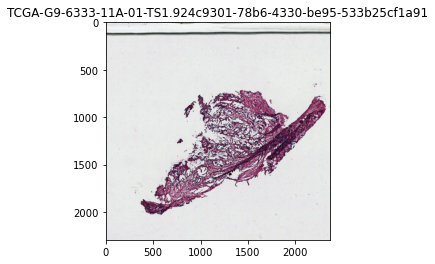

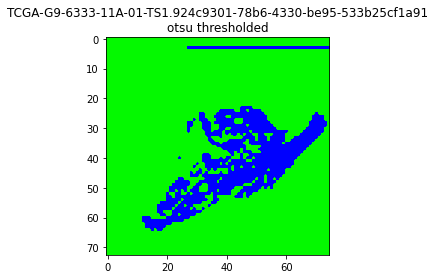

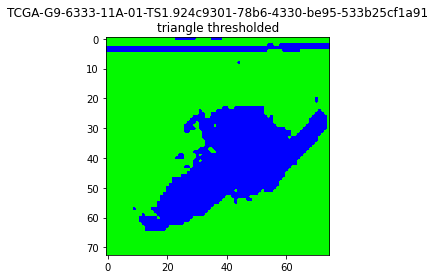

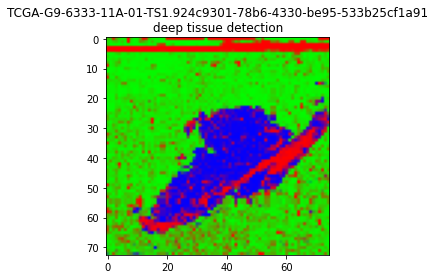

In [24]:
for case in cases[24:]:
    pathml_slide = Slide(os.path.join(analysis_dir_path, 'pathml_slides', case+'.pml'))
    pathml_slide.visualizeThumbnail(folder=os.path.join(analysis_dir_path, 'results'), level=2)
    pathml_slide.visualizeForeground('otsu', folder=os.path.join(analysis_dir_path, 'results'))
    pathml_slide.visualizeForeground('triangle', folder=os.path.join(analysis_dir_path, 'results'))
    pathml_slide.visualizeTissueDetection(folder=os.path.join(analysis_dir_path, 'results'))

We see that in addition to not having any artifact detection capabilities, Otsu's method excludes lighter-colored tissue from the central region of the upper tissue section, whereas the triangle method erroniously includes dark slide artifact regions around the edge of the slide to be tissue. The deep tissue detector seems to be performing well, and we can verify this by checking all of the deep tissue detector class map images we generated alongside all of our trainval slides in the same directory we stored our PathML slides.

Now we can iterate over all tiles in the WSIs to compare the Otsu, triangle, and deep tissue detector results for identifying tissue regions with the annotated ground truth

In [25]:
start_time = time.time()

ground_truth_tissue_overlaps_all_slides = {}
otsu_classifications_all_slides = {}
triangle_classifications_all_slides = {}
dtd_tissue_probs_all_slides = {}
dtd_artifact_probs_all_slides = {}
dtd_background_probs_all_slides = {}

for case in cases:
    ground_truth_tissue_overlaps = []
    otsu_classifications = []
    triangle_classifications = []
    dtd_tissue_probs = []
    dtd_artifact_probs = []
    dtd_background_probs = []
    
    pathml_slide = Slide(os.path.join(analysis_dir_path, 'pathml_slides', case+'.pml'))

    for tile_coords in pathml_slide.iterateTiles():
        tile_data = pathml_slide.tileDictionary[tile_coords]

        ground_truth_tissue_overlaps.append(tile_data['tissueOverlap'])
        otsu_classifications.append(tile_data['foregroundOtsu'])
        triangle_classifications.append(tile_data['foregroundTriangle'])
        dtd_tissue_probs.append(tile_data['tissueLevel'])
        dtd_artifact_probs.append(tile_data['artifactLevel'])
        dtd_background_probs.append(tile_data['backgroundLevel'])
    
    ground_truth_tissue_overlaps_all_slides[case] = ground_truth_tissue_overlaps
    otsu_classifications_all_slides[case] = otsu_classifications
    triangle_classifications_all_slides[case] = triangle_classifications
    dtd_tissue_probs_all_slides[case] = dtd_tissue_probs
    dtd_artifact_probs_all_slides[case] = dtd_artifact_probs
    dtd_background_probs_all_slides[case] = dtd_background_probs
        
        
time_elapsed = time.time() - start_time
print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Complete in 0m 6s


Next let's use these data to calculate the accuracy of each tissue detection method (Otsu, triangle, deep tissue detector) for each slide

In [26]:
#print('GROUND TRUTH')
#print(ground_truth_tissue_overlaps_all_slides['TCGA-2G-AAGK-01Z-00-DX1.D0530A91-8CA1-47AA-95AF-AB7B901DC5B6'])
#print('DEEP TISSUE DETECTOR')
#print(dtd_tissue_probs_all_slides['TCGA-2G-AAGK-01Z-00-DX1.D0530A91-8CA1-47AA-95AF-AB7B901DC5B6'])

# sensitivity to tissue class
#methods = ['deep_tissue_detector', 'otsu', 'triangle']
#results = {case: {method: {}} for case in cases}
results = {'case_names': cases, 
          'deep_tissue_detector_acc': [], 'otsu_acc': [], 'triangle_acc': [],
          'deep_tissue_detector_bal_acc': [], 'otsu_bal_acc': [], 'triangle_bal_acc': [],
           'deep_tissue_detector_tissue_prec': [], 'otsu_tissue_prec': [], 'triangle_tissue_prec': [],
           'deep_tissue_detector_tissue_rec': [], 'otsu_tissue_rec': [], 'triangle_tissue_rec': [],
           'deep_tissue_detector_tissue_f1': [], 'otsu_tissue_f1': [], 'triangle_tissue_f1': [],
        'deep_tissue_detector_background_prec': [], 'otsu_background_prec': [], 'triangle_background_prec': [],
           'deep_tissue_detector_background_rec': [], 'otsu_background_rec': [], 'triangle_background_rec': [],
           'deep_tissue_detector_background_f1': [], 'otsu_background_f1': [], 'triangle_background_f1': []}

for case in cases:
    ground_truth = [i > 0.9 for i in ground_truth_tissue_overlaps_all_slides[case]]
    deep_tissue_detector = [i > 0.3 for i in dtd_tissue_probs_all_slides[case]]
    #print(deep_tissue_detector)
    otsu = otsu_classifications_all_slides[case]
    triangle = triangle_classifications_all_slides[case]
    
    results['deep_tissue_detector_acc'].append(accuracy_score(ground_truth, deep_tissue_detector))
    results['otsu_acc'].append(accuracy_score(ground_truth, otsu))
    results['triangle_acc'].append(accuracy_score(ground_truth, triangle))
    
    results['deep_tissue_detector_bal_acc'].append(balanced_accuracy_score(ground_truth, deep_tissue_detector))
    results['otsu_bal_acc'].append(balanced_accuracy_score(ground_truth, otsu))
    results['triangle_bal_acc'].append(balanced_accuracy_score(ground_truth, triangle))
    
    results['deep_tissue_detector_tissue_prec'].append(precision_score(ground_truth, deep_tissue_detector, pos_label=True, average='binary'))
    results['otsu_tissue_prec'].append(precision_score(ground_truth, otsu, pos_label=True, average='binary'))
    results['triangle_tissue_prec'].append(precision_score(ground_truth, triangle, pos_label=True, average='binary'))
    
    results['deep_tissue_detector_tissue_rec'].append(recall_score(ground_truth, deep_tissue_detector, pos_label=True, average='binary'))
    results['otsu_tissue_rec'].append(recall_score(ground_truth, otsu, pos_label=True, average='binary'))
    results['triangle_tissue_rec'].append(recall_score(ground_truth, triangle, pos_label=True, average='binary'))
    
    results['deep_tissue_detector_tissue_f1'].append(f1_score(ground_truth, deep_tissue_detector, pos_label=True, average='binary'))
    results['otsu_tissue_f1'].append(f1_score(ground_truth, otsu, pos_label=True, average='binary'))
    results['triangle_tissue_f1'].append(f1_score(ground_truth, triangle, pos_label=True, average='binary'))
    
    results['deep_tissue_detector_background_prec'].append(precision_score(ground_truth, deep_tissue_detector, pos_label=False, average='binary'))
    results['otsu_background_prec'].append(precision_score(ground_truth, otsu, pos_label=False, average='binary'))
    results['triangle_background_prec'].append(precision_score(ground_truth, triangle, pos_label=False, average='binary'))
    
    results['deep_tissue_detector_background_rec'].append(recall_score(ground_truth, deep_tissue_detector, pos_label=False, average='binary'))
    results['otsu_background_rec'].append(recall_score(ground_truth, otsu, pos_label=False, average='binary'))
    results['triangle_background_rec'].append(recall_score(ground_truth, triangle, pos_label=False, average='binary'))
    
    results['deep_tissue_detector_background_f1'].append(f1_score(ground_truth, deep_tissue_detector, pos_label=False, average='binary'))
    results['otsu_background_f1'].append(f1_score(ground_truth, otsu, pos_label=False, average='binary'))
    results['triangle_background_f1'].append(f1_score(ground_truth, triangle, pos_label=False, average='binary'))
    
    
    
    
    
    
    
    print(case)
    print('deep tissue detector accuracy: ', accuracy_score(ground_truth, deep_tissue_detector))
    print('otsu accuracy: ', accuracy_score(ground_truth, otsu))
    print('triangle accuracy: ', accuracy_score(ground_truth, triangle))
    print()

    


TCGA-2G-AAGK-01Z-00-DX1.D0530A91-8CA1-47AA-95AF-AB7B901DC5B6
deep tissue detector accuracy:  0.9401360544217687
otsu accuracy:  0.8258503401360544
triangle accuracy:  0.9697656840513983

TCGA-2G-AAHN-01Z-00-DX1.B5CCB104-C436-4B80-8F47-EB9C7D13ACF0
deep tissue detector accuracy:  0.9319183268168559
otsu accuracy:  0.8228138769937318
triangle accuracy:  0.9630112331657668

TCGA-2G-AAKD-01Z-00-DX1.137A7B81-38C0-4715-BF9A-64BDB219DB9A
deep tissue detector accuracy:  0.9619406768918748
otsu accuracy:  0.8414881480542528
triangle accuracy:  0.9628913677272151

TCGA-2G-AAKO-05Z-00-DX1.2668F339-535C-4981-ADF7-9B47C15ED272
deep tissue detector accuracy:  0.9607095046854083
otsu accuracy:  0.8998326639892905
triangle accuracy:  0.9841700133868808

TCGA-YU-A94D-01Z-00-DX1.9B1832C3-F7CA-410A-AC74-28FCB282D05D
deep tissue detector accuracy:  0.933668368863311
otsu accuracy:  0.9528788738483154
triangle accuracy:  0.9429899219151063

TCGA-XE-A8H1-01A-01-TS1.12D10019-B0AC-4476-88F1-6996102A0D22
deep 

In [30]:
for metric, metric_values in results.items():
    if metric is not 'case_names':
        print('Average '+metric+':', sum(metric_values)/len(metric_values))

Average deep_tissue_detector_acc: 0.9465208398615407
Average otsu_acc: 0.8684518049082363
Average triangle_acc: 0.8826902856455483
Average deep_tissue_detector_bal_acc: 0.9454579074768223
Average otsu_bal_acc: 0.7881849573391241
Average triangle_bal_acc: 0.8835555548494902
Average deep_tissue_detector_tissue_prec: 0.7435654576487032
Average otsu_tissue_prec: 0.6815754778332845
Average triangle_tissue_prec: 0.6129554655789625
Average deep_tissue_detector_tissue_rec: 0.9491808510414894
Average otsu_tissue_rec: 0.6281644525523362
Average triangle_tissue_rec: 0.8778463215617827
Average deep_tissue_detector_tissue_f1: 0.8117675442732577
Average otsu_tissue_f1: 0.6140546416435668
Average triangle_tissue_f1: 0.6748672769966049
Average deep_tissue_detector_background_prec: 0.9796993765408828
Average otsu_background_prec: 0.8758050309882918
Average triangle_background_prec: 0.9532181336405432
Average deep_tissue_detector_background_rec: 0.9417349639121544
Average otsu_background_rec: 0.94820546

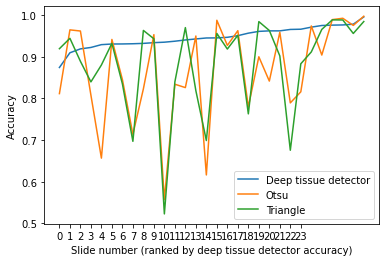

In [33]:
dtt_acc_sorted, otsu_acc_sorted, triangle_acc_sorted = zip(*sorted(zip(results['deep_tissue_detector_acc'], results['otsu_acc'], results['triangle_acc'])))

plt.plot(dtt_acc_sorted, label='Deep tissue detector')
plt.plot(otsu_acc_sorted, label='Otsu')
plt.plot(triangle_acc_sorted, label='Triangle')
plt.xlabel('Slide number (ranked by deep tissue detector accuracy)')
plt.ylabel('Accuracy')
plt.xticks(range(0,24))
plt.legend()
plt.show()

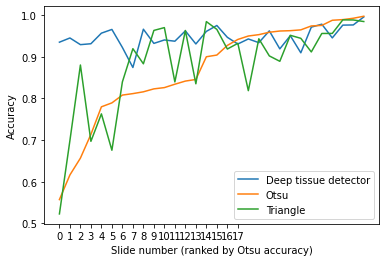

In [32]:
otsu_acc_sorted, dtt_acc_sorted, triangle_acc_sorted = zip(*sorted(zip(results['otsu_acc'], results['deep_tissue_detector_acc'], results['triangle_acc'])))

plt.plot(dtt_acc_sorted, label='Deep tissue detector')
plt.plot(otsu_acc_sorted, label='Otsu')
plt.plot(triangle_acc_sorted, label='Triangle')
plt.xlabel('Slide number (ranked by Otsu accuracy)')
plt.ylabel('Accuracy')
plt.xticks(range(0,18))
plt.legend()
plt.show()

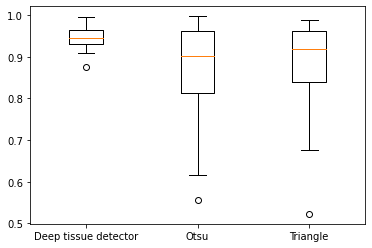

In [31]:
acc_dict = {"Deep tissue detector": results['deep_tissue_detector_acc'], 'Otsu': results['otsu_acc'], 'Triangle': results['triangle_acc']}
fig, ax = plt.subplots()
ax.boxplot(acc_dict.values())
ax.set_xticklabels(acc_dict.keys())
plt.show()

In [13]:
tile_size = 500 # pixels
tcga_prad_slides = [str(path) for path in Path('/media/berman01/Seagate Expansion Drive/tcga_prad').glob('**/*.svs')]
print(tcga_prad_slides)
for tcga_prad_slide in ['/media/berman01/Seagate Expansion Drive/tcga_prad/TCGA-G9-6333-11A-01-TS1.924c9301-78b6-4330-be95-533b25cf1a91.svs', '/media/berman01/Seagate Expansion Drive/tcga_prad/TCGA-CH-5768-01Z-00-DX1.4c6626ea-a1fb-4aca-8970-a40035025174.svs']:#tcga_prad_slides[22:]:
    path = tcga_prad_slide
    example_slide = Slide(path, level=0).setTileProperties(tileSize=tile_size)
    example_slide.detectForeground(level=2)
    example_slide.detectTissue()

    #for slide in example_slide:
    #example_slide = Slide(os.path.join(analysis_dir_path, 'pathml_slides', case+'.pml'))
    example_slide.visualizeThumbnail(folder=os.path.join(analysis_dir_path, 'results'), level=2)
    example_slide.visualizeForeground('otsu', folder=os.path.join(analysis_dir_path, 'results'))
    example_slide.visualizeForeground('triangle', folder=os.path.join(analysis_dir_path, 'results'))
    example_slide.visualizeTissueDetection(folder=os.path.join(analysis_dir_path, 'results'))

[]


FileNotFoundError: Whole-slide image could not be loaded